In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from statsmodels.tsa.stattools import adfuller
import arviz as az # Import arviz to handle the trace object
import warnings
warnings.filterwarnings("ignore")


In [23]:
df=pd.read_csv('../Data/BrentOilPrices.csv')

In [24]:
df

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63
...,...,...
9006,"Nov 08, 2022",96.85
9007,"Nov 09, 2022",93.05
9008,"Nov 10, 2022",94.25
9009,"Nov 11, 2022",96.37


In [25]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [31]:
df

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25


In [36]:
# Perform ADF Test for Stationarity
def adf_test(data):
    adf_result = adfuller(data['Price'])
    print(f'ADF Statistic: {adf_result[0]:.2f}')
    print(f'p-value: {adf_result[1]:.4f}')
    return adf_result[1] < 0.05  # True if stationary

In [ ]:

# Bayesian Change Point Model
def change_point_model(data):
    prices = data['Price'].values
    with pm.Model() as model:
        tau = pm.DiscreteUniform('tau', lower=0, upper=len(prices) - 1)
        mu_1 = pm.Normal('mu_1', mu=prices.mean(), sigma=10)
        mu_2 = pm.Normal('mu_2', mu=prices.mean(), sigma=10)
        idx = np.arange(len(prices))

        mu = pm.Deterministic('mu', pm.math.switch(idx < tau, mu_1, mu_2))
        likelihood = pm.Normal('y', mu=mu, sigma=1, observed=prices)
        trace = pm.sample(2000, tune=1000, target_accept=0.95)
    return trace

In [38]:
# Plotting Change Point Results
def plot_change_points(trace):
    # Access the 'tau' samples from the posterior group of the trace
    tau_samples = trace.posterior['tau'].values.flatten()
    
    plt.figure(figsize=(10, 5))
    plt.hist(tau_samples, bins=30, alpha=0.5)
    plt.xlabel('Change Point (tau)')
    plt.ylabel('Frequency')
    plt.title('Posterior Distribution of Change Point')
    plt.show()

ADF Statistic: -1.99
p-value: 0.2893
Stationary: False
Fitting Bayesian Change Point Model...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


Model fitting complete.


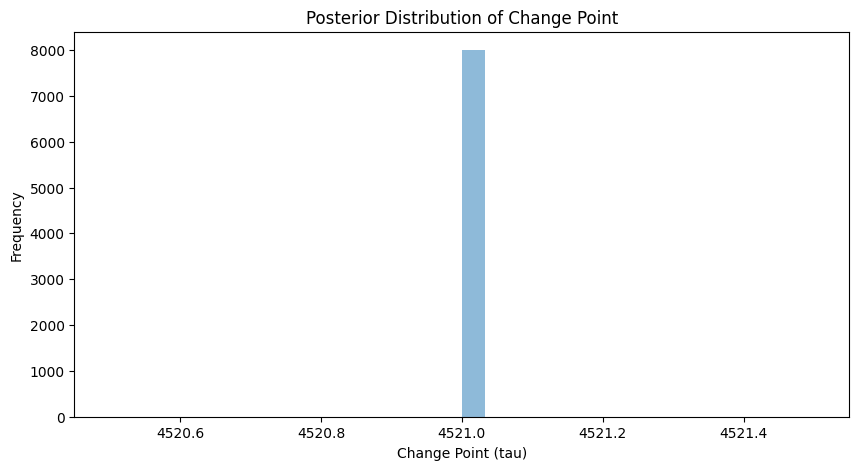

Estimated Change Point Index: 4521
Estimated Change Point Date: 2005-02-24 00:00:00
Average Price Before Change: $21.42
Average Price After Change: $75.61
Percentage Change: 252.99%
Note: The change point on 2005-02-24 is not a direct match for the OPEC Cut event on 2020-04-12.
Note: The change point on 2005-02-24 is not a direct match for the COVID-19 Pandemic event on 2020-03-01.


In [39]:
# Main Execution
if __name__ == "__main__":
    # Perform stationarity test
    is_stationary = adf_test(df)
    print(f'Stationary: {is_stationary}')

    # Fit Change Point Model
    print("Fitting Bayesian Change Point Model...")
    trace = change_point_model(df)
    print("Model fitting complete.")

    # Plot results
    plot_change_points(trace)

    # Analyzing change points
    # Access the samples from the posterior group
    change_point_estimate = np.mean(trace.posterior['tau'].values.flatten())
    estimated_index = int(round(change_point_estimate))
    estimated_date = df.index[estimated_index]
    
    print(f'Estimated Change Point Index: {estimated_index}')
    print(f'Estimated Change Point Date: {estimated_date}')

    # Quantifying impact
    before_change = df['Price'].iloc[:estimated_index].mean()
    after_change = df['Price'].iloc[estimated_index:].mean()
    percentage_change = ((after_change - before_change) / before_change) * 100

    print(f'Average Price Before Change: ${before_change:.2f}')
    print(f'Average Price After Change: ${after_change:.2f}')
    print(f'Percentage Change: {percentage_change:.2f}%')

    # Associate with events (hypothetical)
    events = {
        "OPEC Cut": "2020-04-12",
        "COVID-19 Pandemic": "2020-03-01"
    }
    
    # Check if any event date is close to the estimated change point date
    for event, date_str in events.items():
        event_date = pd.to_datetime(date_str)
        if event_date.date() == estimated_date.date():
            print(f'Change point on {estimated_date.date()} is likely associated with {event}.')
        else:
            print(f'Note: The change point on {estimated_date.date()} is not a direct match for the {event} event on {event_date.date()}.')
